# Trump's tone to Congress

We're going to reproduce [Trump Sounds a Different Tone in First Address to Congress](https://www.nytimes.com/interactive/2017/02/28/upshot/trump-sounds-different-tone-in-first-address-to-congress.html) from the Upshot.

**Datasource 1:** The [NRC Emotional Lexicon](http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm), a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). The annotations were manually done by crowdsourcing. 

**Datasource 2:** A database of [Trump speeches](https://github.com/PedramNavid/trump_speeches), one speech per file. There are a lot of GitHub repositories of Trump speeches, but this one is better than the vast majority.

**Datasource 3:** State of the Union addresses taken from [this repo's data directory](https://github.com/m-aleem/SOTU-Analyzer). I also cheated and pasted Trump's SOTU-y address in.

In [11]:
import pandas as pd
%matplotlib inline

# Reading in the EmoLex

I'm just copying this from the other notebook! It's the one at the very bottom that does a lot of reshaping. I think it's the easiest to work with.

In [12]:
filepath = "NRC-Emotion-Lexicon-v0.92/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df = emolex_df.pivot(index='word', columns='emotion', values='association').reset_index()
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,1,0,0
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0


## Reading in Trump's speeches

### Get a list of all of the files

In [14]:
import glob

filenames = glob.glob("trump_speeches-master/data/speech*")
filenames[:5]

['trump_speeches-master/data/speech_0.txt',
 'trump_speeches-master/data/speech_1.txt',
 'trump_speeches-master/data/speech_10.txt',
 'trump_speeches-master/data/speech_11.txt',
 'trump_speeches-master/data/speech_12.txt']

### Read them all in individually

In [15]:
speeches = [open(filename).read() for filename in filenames]
len(speeches)

56

### Create a dataframe out of the results

Instead of passing a list of dictionaries to `pd.DataFrame`, we pass a dictionary that says "here are all of the filenames" and "here are all of the texts" and it puts each list into a column.

In [16]:
speeches_df = pd.DataFrame({
    'text': speeches,
    'filename': filenames
})
speeches_df.head(3)

,filename,text
0,trump_speeches-master/data/speech_0.txt,Remarks Announcing Candidacy for President in ...
1,trump_speeches-master/data/speech_1.txt,Remarks at the AIPAC Policy Conference in Wash...
2,trump_speeches-master/data/speech_10.txt,Remarks at the Washington County Fair Park in ...


### Splitting out the title and content of the speech

The "text" column is formatted with first the title of the speech, then the text. Like this:

In [17]:
speeches_df.loc[0]['text'][:200]

"Remarks Announcing Candidacy for President in New York City\nTrump: Wow. Whoa. That is some group of people. Thousands.So nice, thank you very much. That's really nice. Thank you. It's great to be at T"

We're going to split those out into multiple columns, then delete the original column so we don't get mixed up later.

In [18]:
speeches_df['name'] = speeches_df['text'].apply(lambda value: value.split("\n")[0])
speeches_df['content'] = speeches_df['text'].apply(lambda value: value.split("\n")[1])
del speeches_df['text']
speeches_df.head(2)

,filename,name,content
0,trump_speeches-master/data/speech_0.txt,Remarks Announcing Candidacy for President in ...,Trump: Wow. Whoa. That is some group of people...
1,trump_speeches-master/data/speech_1.txt,Remarks at the AIPAC Policy Conference in Wash...,Good evening. Thank you very much. I speak to...


# How does Trump sound?

Let's analyze by counting words.

We would use the code below to count all of his words. **Do we really want all of them?**

```python
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
matrix = vec.fit_transform(speeches_df['content'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()
```

In [70]:
emolex_df['word'].head(3)

0      aback
1     abacus
2    abandon
Name: word, dtype: object

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# I only want you to look for words in the emotional lexicon
# because we don't know what's up with the other words
vec = TfidfVectorizer(vocabulary=emolex_df.word,
                      use_idf=False, 
                      norm='l1') # ELL - ONE
matrix = vec.fit_transform(speeches_df['content'])
vocab = vec.get_feature_names()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

,aback,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,abbreviate,...,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
0,0.0,0.0,0.0,0.000677,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.001321,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# wordcount_df.sort_values(by='america', ascending=False).head(5)

In [56]:
# wordcount_df[['murder', 'america', 'great', 'prison', 'immigrant']].head(2)

In [57]:
# bad bad bad = 100% negative
# bad bad evil evil = 50% bad + 50% evil = 100% negative
# bad fish evil fish = 25% bad + 25% evil = 50% negative 
# awful % + hate % + bad % + worse % + evil % = negative %

wordcount_df[['awful', 'hate', 'bad', 'worse', 'evil']].sum(axis=1)

0     0.007442
1     0.010121
2     0.007926
3     0.003871
4     0.001709
5     0.000000
6     0.005051
7     0.000000
8     0.000000
9     0.001506
10    0.001391
11    0.013943
12    0.002304
13    0.000000
14    0.004525
15    0.000000
16    0.000000
17    0.002066
18    0.004785
19    0.001166
20    0.000000
21    0.000000
22    0.004367
23    0.007979
24    0.000000
25    0.001626
26    0.001873
27    0.000000
28    0.002008
29    0.000000
30    0.000000
31    0.006631
32    0.000000
33    0.002976
34    0.002535
35    0.001511
36    0.003810
37    0.000000
38    0.000000
39    0.001658
40    0.001802
41    0.000000
42    0.003704
43    0.001812
44    0.002165
45    0.002976
46    0.002247
47    0.003937
48    0.001592
49    0.000000
50    0.003401
51    0.002950
52    0.002430
53    0.005650
54    0.014153
55    0.009298
dtype: float64

In [58]:
# speeches_df['negative'] = wordcount_df[['awful', 'hate', 'bad', 'worse', 'evil']].sum(axis=1)
# speeches_df.head(3)

,filename,name,content,negative,policy
0,trump_speeches-master/data/speech_0.txt,Remarks Announcing Candidacy for President in ...,Trump: Wow. Whoa. That is some group of people...,0.007442,0.00128
1,trump_speeches-master/data/speech_1.txt,Remarks at the AIPAC Policy Conference in Wash...,Good evening. Thank you very much. I speak to...,0.010121,0.00000
2,trump_speeches-master/data/speech_10.txt,Remarks at the Washington County Fair Park in ...,It's so great to be here tonight. I am honored...,0.007926,0.00709


In [59]:
# speeches_df['policy'] = wordcount_df[['crime', 'discrimination', 'poverty', 'border']].sum(axis=1)
# speeches_df.head(3)

In [60]:
# speeches_df.plot(x='negative', 
#                  y='policy', 
#                  kind='scatter',
#                  ylim=(0,0.01),
#                  xlim=(0,0.005))

In [61]:
emolex_df.head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,1,0,0
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0


In [62]:
emolex_df[emolex_df.anger == 1].head()

emotion,word,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
3,abandoned,1,0,0,1,0,1,0,1,0,0
4,abandonment,1,0,0,1,0,1,0,1,1,0
17,abhor,1,0,1,1,0,1,0,0,0,0
18,abhorrent,1,0,1,1,0,1,0,0,0,0
27,abolish,1,0,0,0,0,1,0,0,0,0


In [63]:
# Get your list of angry words
angry_words = emolex_df[emolex_df.anger == 1]['word']
angry_words.head()

3       abandoned
4     abandonment
17          abhor
18      abhorrent
27        abolish
Name: word, dtype: object

In [68]:
wordcount_df[angry_words].head()

,abandoned,abandonment,abhor,abhorrent,abolish,abomination,abuse,accursed,accusation,accused,...,wreck,wrecked,wretch,wring,wrongdoing,wrongful,wrongly,yell,yelp,youth
0,0.000677,0.0,0.0,0.0,0.0,0.0,0.000677,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001321,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# Only give me the columns of angry words
speeches_df['anger'] = wordcount_df[angry_words].sum(axis=1)
speeches_df.head(3)

,filename,name,content,negative,policy,anger
0,trump_speeches-master/data/speech_0.txt,Remarks Announcing Candidacy for President in ...,Trump: Wow. Whoa. That is some group of people...,0.007442,0.00128,0.055480
1,trump_speeches-master/data/speech_1.txt,Remarks at the AIPAC Policy Conference in Wash...,Good evening. Thank you very much. I speak to...,0.010121,0.00000,0.099190
2,trump_speeches-master/data/speech_10.txt,Remarks at the Washington County Fair Park in ...,It's so great to be here tonight. I am honored...,0.007926,0.00709,0.133421


In [74]:
# Get your list of positive words
positive_words = emolex_df[emolex_df.positive == 1]['word']

# Only give me the columns of angry words
speeches_df['positivity'] = wordcount_df[positive_words].sum(axis=1)
speeches_df.head(3)

,filename,name,content,negative,policy,anger,positivity
0,trump_speeches-master/data/speech_0.txt,Remarks Announcing Candidacy for President in ...,Trump: Wow. Whoa. That is some group of people...,0.007442,0.00128,0.055480,0.261164
1,trump_speeches-master/data/speech_1.txt,Remarks at the AIPAC Policy Conference in Wash...,Good evening. Thank you very much. I speak to...,0.010121,0.00000,0.099190,0.315789
2,trump_speeches-master/data/speech_10.txt,Remarks at the Washington County Fair Park in ...,It's so great to be here tonight. I am honored...,0.007926,0.00709,0.133421,0.214003


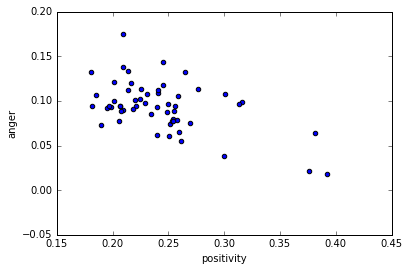

In [75]:
speeches_df.plot(x='positivity', y='anger', kind='scatter')

# Reading in the SOTU addresses

Pretty much the same thing as what we did with Trump!

In [76]:
# Get the filenames
# Read them in
# Create a dataframe from the results
filenames = glob.glob("SOTU/*.txt")
contents = [open(filename).read() for filename in filenames]
sotu_df = pd.DataFrame({
    'content': contents,
    'filename': filenames
})
sotu_df.head(3)

,content,filename
0,Gentlemen of the Congress:\n\nIn pursuance of ...,SOTU/1913.txt
1,GENTLEMEN OF THE CONGRESS:\n\nThe session upon...,SOTU/1914.txt
2,GENTLEMEN OF THE CONGRESS:\n\nSince I last had...,SOTU/1915.txt


### Add a column for the name 

We don't have a name for these, so we'll just use the filename.

In [77]:
sotu_df['name'] = sotu_df['filename']
sotu_df.head()

,content,filename,name
0,Gentlemen of the Congress:\n\nIn pursuance of ...,SOTU/1913.txt,SOTU/1913.txt
1,GENTLEMEN OF THE CONGRESS:\n\nThe session upon...,SOTU/1914.txt,SOTU/1914.txt
2,GENTLEMEN OF THE CONGRESS:\n\nSince I last had...,SOTU/1915.txt,SOTU/1915.txt
3,GENTLEMEN OF THE CONGRESS:\n\nIn fulfilling at...,SOTU/1916.txt,SOTU/1916.txt
4,Gentlemen of the Congress:\n\nEight months hav...,SOTU/1917.txt,SOTU/1917.txt


# How do State of the Unions sound?

Let's analyze by counting words.

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

# I only want you to look for words in the emotional lexicon
# because we don't know what's up with the other words
vec = TfidfVectorizer(vocabulary=emolex_df.word,
                      use_idf=False, 
                      norm='l1') # ELL - ONE
matrix = vec.fit_transform(sotu_df['content'])
vocab = vec.get_feature_names()
sotu_wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
sotu_wordcount_df.head()

,aback,abacus,abandon,abandoned,abandonment,abate,abatement,abba,abbot,abbreviate,...,zephyr,zeppelin,zest,zip,zodiac,zone,zoo,zoological,zoology,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000923,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
# Get your list of positive words
positive_words = emolex_df[emolex_df.positive == 1]['word']

# Only give me the columns of angry words
sotu_df['positivity'] = sotu_wordcount_df[positive_words].sum(axis=1)
sotu_df.head(3)

,content,filename,name,positivity,anger
0,Gentlemen of the Congress:\n\nIn pursuance of ...,SOTU/1913.txt,SOTU/1913.txt,0.272425,0.019934
1,GENTLEMEN OF THE CONGRESS:\n\nThe session upon...,SOTU/1914.txt,SOTU/1914.txt,0.277932,0.042475
2,GENTLEMEN OF THE CONGRESS:\n\nSince I last had...,SOTU/1915.txt,SOTU/1915.txt,0.267757,0.051099


In [85]:
# Get your list of positive words
angry_words = emolex_df[emolex_df.anger == 1]['word']

# Only give me the columns of angry words
sotu_df['anger'] = sotu_wordcount_df[angry_words].sum(axis=1)
sotu_df.head(3)

,content,filename,name,positivity,anger
0,Gentlemen of the Congress:\n\nIn pursuance of ...,SOTU/1913.txt,SOTU/1913.txt,0.272425,0.019934
1,GENTLEMEN OF THE CONGRESS:\n\nThe session upon...,SOTU/1914.txt,SOTU/1914.txt,0.277932,0.042475
2,GENTLEMEN OF THE CONGRESS:\n\nSince I last had...,SOTU/1915.txt,SOTU/1915.txt,0.267757,0.051099


# Comparing SOTU vs Trump

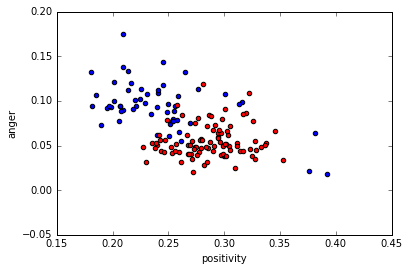

In [88]:
ax = speeches_df.plot(x='positivity', y='anger', kind='scatter')
sotu_df.plot(x='positivity', y='anger', kind='scatter', c='red', ax=ax)